In [2]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from xgboost import XGBClassifier

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [3]:
batch_size = 32

# Simple Dataset

In [20]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

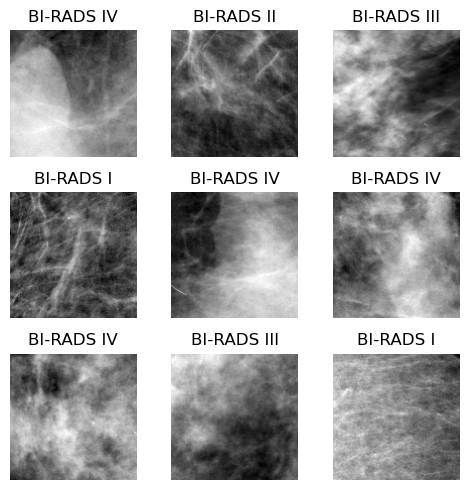

In [21]:
sample_images(dataloaders['test'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

## VAE

In [113]:
kwargs, state = torch.load("models/final/simple/vae.pt")

model = VAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

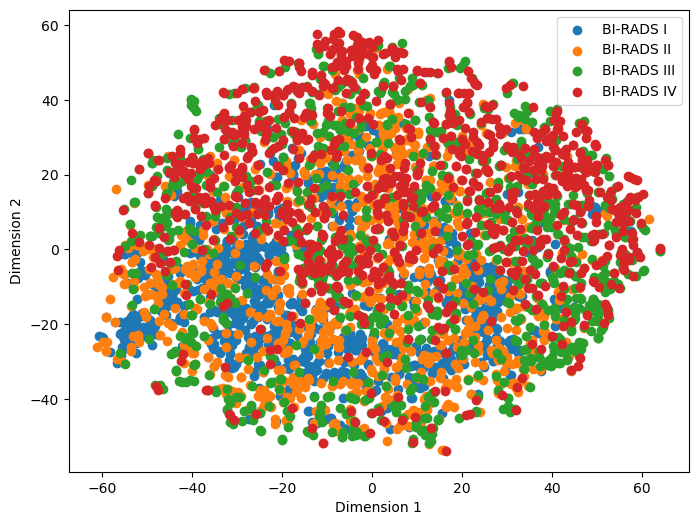

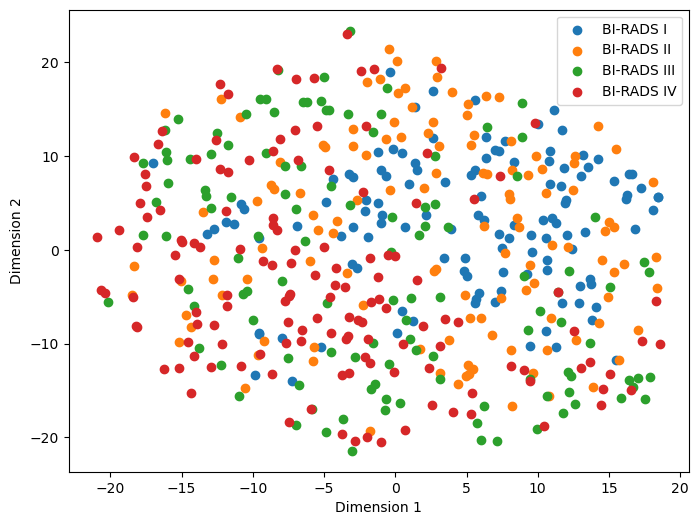

In [114]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [115]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [116]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [117]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(classification_report(labels, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.78      0.72       121
           1       0.53      0.48      0.50       124
           2       0.53      0.47      0.50       119
           3       0.60      0.63      0.61       139

    accuracy                           0.59       503
   macro avg       0.58      0.59      0.58       503
weighted avg       0.58      0.59      0.58       503



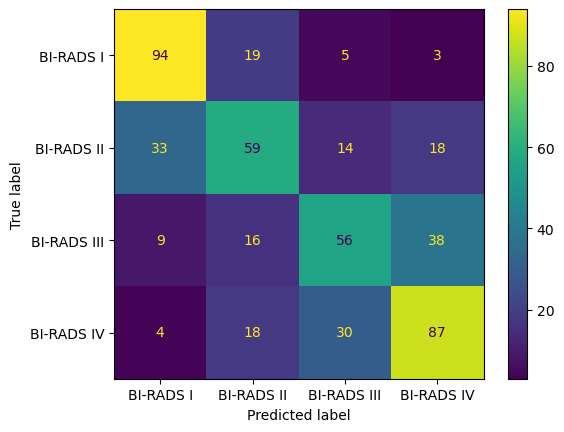

In [118]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [119]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.5885
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       121
           1       0.53      0.48      0.50       124
           2       0.53      0.47      0.50       119
           3       0.60      0.63      0.61       139

    accuracy                           0.59       503
   macro avg       0.58      0.59      0.58       503
weighted avg       0.58      0.59      0.58       503



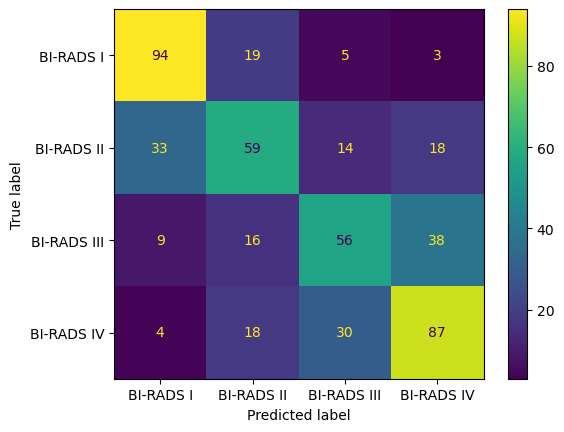

In [120]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [121]:
kwargs, state = torch.load("models/final/simple/pvae.pt")

model = PVAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

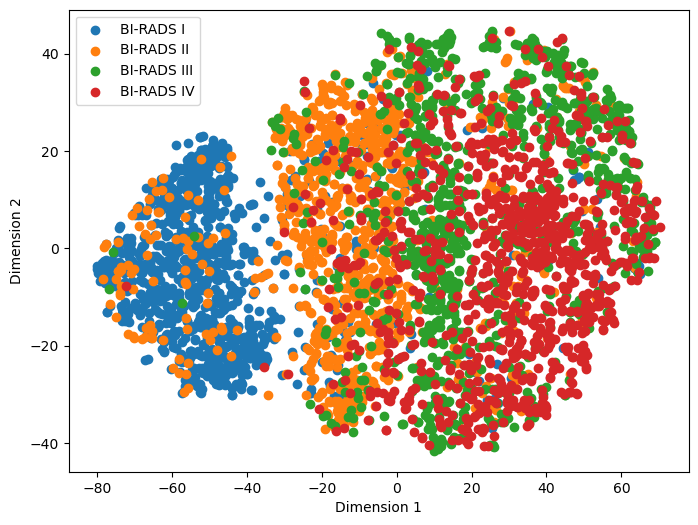

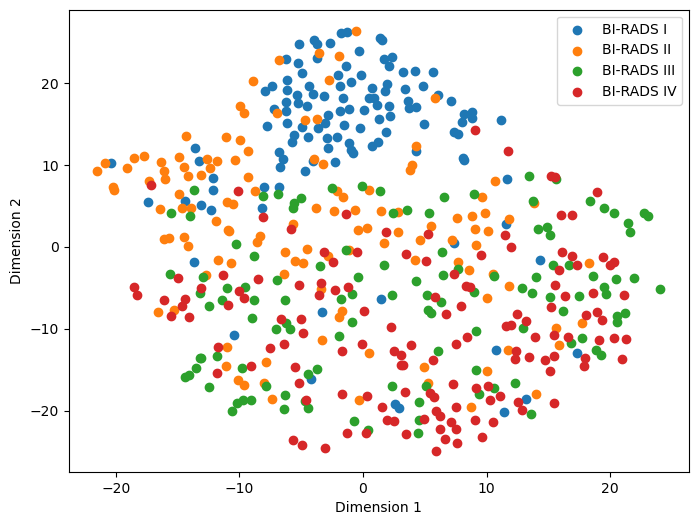

In [122]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [123]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [124]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [125]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(sum(y_pred == labels) / len(labels))

0.6401590457256461


In [126]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       121
           1       0.57      0.61      0.59       124
           2       0.54      0.51      0.53       119
           3       0.61      0.63      0.62       139

    accuracy                           0.64       503
   macro avg       0.64      0.64      0.64       503
weighted avg       0.64      0.64      0.64       503



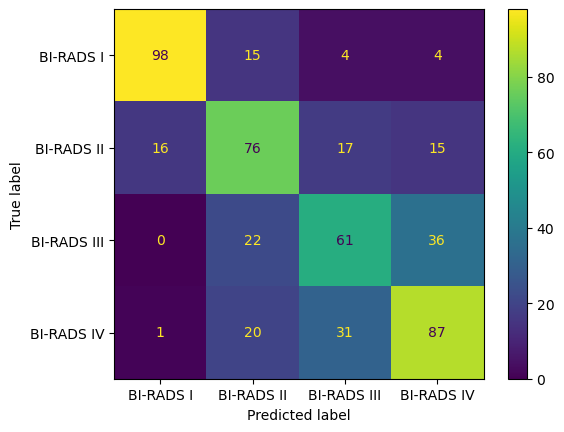

In [127]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [128]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.6402
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       121
           1       0.57      0.61      0.59       124
           2       0.54      0.51      0.53       119
           3       0.61      0.63      0.62       139

    accuracy                           0.64       503
   macro avg       0.64      0.64      0.64       503
weighted avg       0.64      0.64      0.64       503



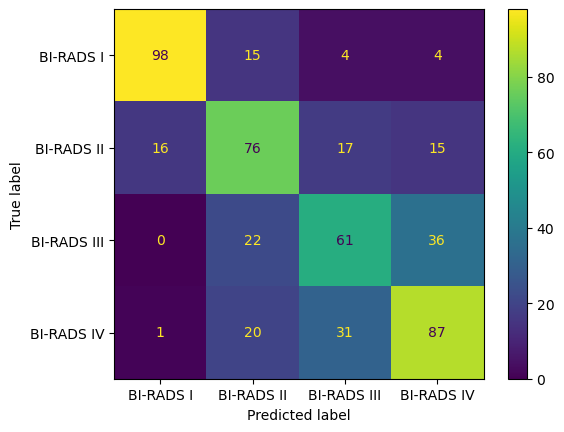

In [129]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

# Sobel Dataset

In [6]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Sobel(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

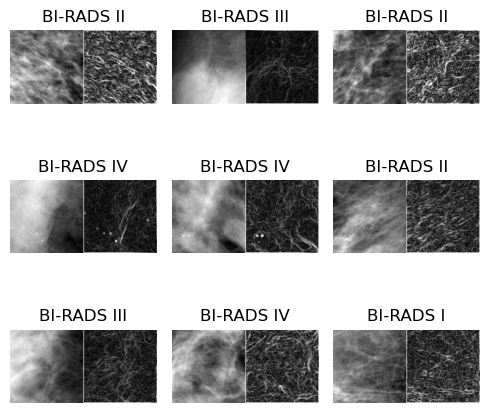

In [7]:
sample_images(dataloaders['test'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

## VAE

In [56]:
kwargs, state = torch.load("models/final/sobel/vae.pt")

model = VAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

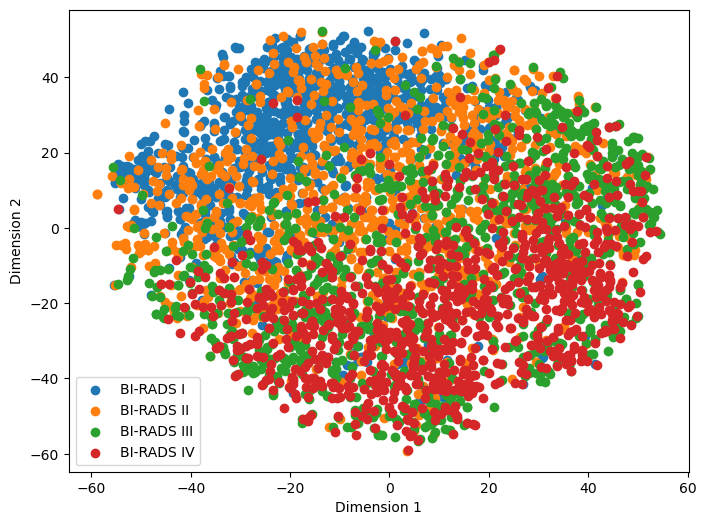

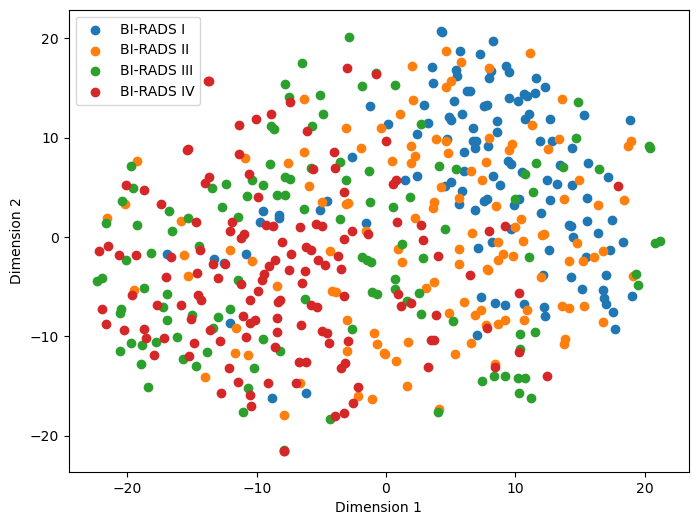

In [57]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [58]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [59]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [67]:
grid_params = {'C':[0.1, 1, 10], 'gamma':['scale', 'auto', 0.1, 0.5, 0.01]}
svm = SVC()
clf = GridSearchCV(svm, grid_params)
clf.fit(train_latent, train_labels)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': ['scale', 'auto', 0.1, 0.5, 0.01]})

In [68]:
df_results = pd.DataFrame(clf.cv_results_)

best_params = df_results[df_results['rank_test_score'] <= 5].params.to_list()

In [69]:
for params in best_params:
    svm = SVC(**params)
    svm.fit(train_latent, train_labels)
    y_pred = svm.predict(latent)
    print(params)
    print(sum(y_pred == labels) / len(labels))

{'C': 0.1, 'gamma': 'scale'}
0.584493041749503
{'C': 0.1, 'gamma': 'auto'}
0.5765407554671969
{'C': 1, 'gamma': 'scale'}
0.5924453280318092
{'C': 1, 'gamma': 'auto'}
0.5964214711729622
{'C': 1, 'gamma': 0.01}
0.5825049701789264


: 

In [66]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
(labels == y_pred).sum() / len(y_pred)

0.5924453280318092

In [61]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       121
           1       0.56      0.55      0.55       124
           2       0.53      0.47      0.50       119
           3       0.57      0.60      0.58       139

    accuracy                           0.59       503
   macro avg       0.59      0.59      0.59       503
weighted avg       0.59      0.59      0.59       503



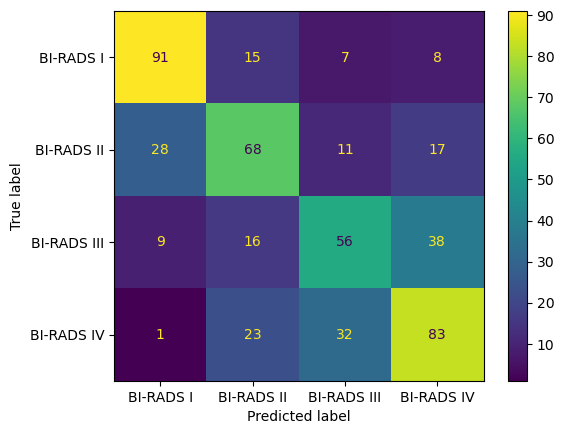

In [62]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [63]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.5924
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       121
           1       0.56      0.55      0.55       124
           2       0.53      0.47      0.50       119
           3       0.57      0.60      0.58       139

    accuracy                           0.59       503
   macro avg       0.59      0.59      0.59       503
weighted avg       0.59      0.59      0.59       503



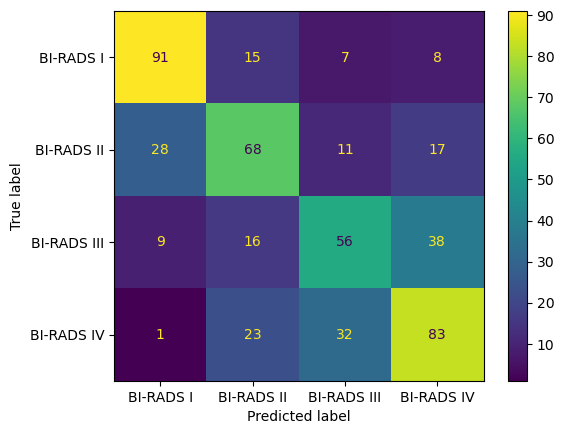

In [64]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [8]:
kwargs, state = torch.load("models/final/sobel/pvae.pt")

model = PVAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

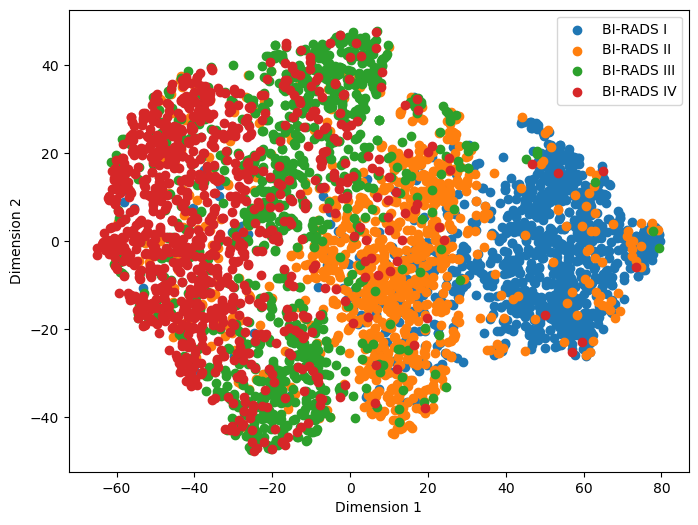

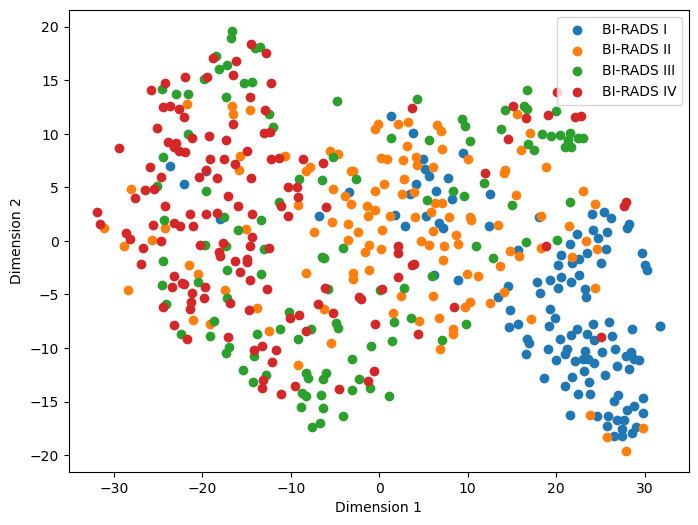

In [9]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [10]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [11]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [12]:
grid_params = {'C':[0.1, 0.5, 1, 2, 4], 'gamma':['scale', 'auto', 0.2, 0.1, 0.5, 0.01]}
svm = SVC()
clf = GridSearchCV(svm, grid_params)
clf.fit(train_latent, train_labels)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 2, 4],
                         'gamma': ['scale', 'auto', 0.2, 0.1, 0.5, 0.01]})

In [13]:
df_results = pd.DataFrame(clf.cv_results_)

best_params = df_results[df_results['rank_test_score'] <= 5].params.to_list()
df_results.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
17       0.556045      0.051106         0.305897        0.004834       1   
12       0.625682      0.016150         0.355069        0.012993       1   
23       0.431991      0.070501         0.212098        0.029914       2   
13       0.631693      0.025758         0.365123        0.025930       1   
7        0.676922      0.031535         0.367189        0.024413     0.5   
6        0.654498      0.058518         0.343986        0.020858     0.5   
18       0.751983      0.097512         0.378182        0.061678       2   
19       0.669509      0.043485         0.355924        0.018820       2   
11       0.633562      0.026505         0.366641        0.040622     0.5   
29       0.390541      0.018945         0.215731        0.042462       4   
1        0.730195      0.031102         0.404577        0.023164     0.1   
5        0.697447      0.033886         0.372425        0.031716     0.1   
0        0.797679      0.035453         0.387655        0.016881     0.1   
24       0.487336      0.039360         0.239344        0.025105       4   
25       0.526261      0.047553         0.259285        0.035752       4   
27       0.966060      0.068510         0.341708        0.046268       4   
21       1.703252      0.076283         0.551644        0.029339       2   
15       1.578920      0.039695         0.520946        0.034485       1   
9        1.510868      0.037443         0.563683        0.033353     0.5   
20       1.634297      0.138783         0.558598        0.031573       2   
26       1.023742      0.083846         0.324562        0.015556       4   
14       1.600957      0.119607         0.506299        0.011466       1   
22       1.158762      0.364752         0.357723        0.030452       2   
28       0.945802      0.051844         0.308936        0.016832       4   
3        1.450248      0.020395         0.563566        0.032475     0.1   
10       1.616937      0.090750         0.523989        0.028618     0.5   
2        1.523998      0.058336         0.549195        0.013887     0.1   
8        1.483850      0.039542         0.547121        0.021033     0.5   
16       1.596483      0.039406         0.499960        0.034746       1   
4        1.526023      0.088042         0.551917        0.023639     0.1   

   param_gamma                        params  split0_test_score  \
17        0.01       {'C': 1, 'gamma': 0.01}           0.741294   
12       scale    {'C': 1, 'gamma': 'scale'}           0.743781   
23        0.01       {'C': 2, 'gamma': 0.01}           0.751244   
13        auto     {'C': 1, 'gamma': 'auto'}           0.743781   
7         auto   {'C': 0.5, 'gamma': 'auto'}           0.740050   
6        scale  {'C': 0.5, 'gamma': 'scale'}           0.736318   
18       scale    {'C': 2, 'gamma': 'scale'}           0.746269   
19        auto     {'C': 2, 'gamma': 'auto'}           0.748756   
11        0.01     {'C': 0.5, 'gamma': 0.01}           0.740050   
29        0.01       {'C': 4, 'gamma': 0.01}           0.747512   
1         auto   {'C': 0.1, 'gamma': 'auto'}           0.723881   
5         0.01     {'C': 0.1, 'gamma': 0.01}           0.721393   
0        scale  {'C': 0.1, 'gamma': 'scale'}           0.721393   
24       scale    {'C': 4, 'gamma': 'scale'}           0.743781   
25        auto     {'C': 4, 'gamma': 'auto'}           0.745025   
27         0.1        {'C': 4, 'gamma': 0.1}           0.692786   
21         0.1        {'C': 2, 'gamma': 0.1}           0.692786   
15         0.1        {'C': 1, 'gamma': 0.1}           0.697761   
9          0.1      {'C': 0.5, 'gamma': 0.1}           0.557214   
20         0.2        {'C': 2, 'gamma': 0.2}           0.526119   
26         0.2        {'C': 4, 'gamma': 0.2}           0.526119   
14         0.2        {'C': 1, 'gamma': 0.2}           0.501244   
22         0.5        {'C': 2, 'gamma': 0.5}           0.254975   
28         0.5        {'C': 4, 'gamma':

In [14]:
for params in best_params:
    svm = SVC(**params)
    svm.fit(train_latent, train_labels)
    y_pred = svm.predict(latent)
    print(params)
    print(sum(y_pred == labels) / len(labels))

{'C': 0.5, 'gamma': 'auto'}
0.6520874751491054
{'C': 1, 'gamma': 'scale'}
0.6620278330019881
{'C': 1, 'gamma': 'auto'}
0.6620278330019881
{'C': 1, 'gamma': 0.01}
0.6600397614314115
{'C': 2, 'gamma': 0.01}
0.6699801192842942


In [15]:
svm = clf.best_estimator_
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(sum(y_pred == labels) / len(labels))

0.6600397614314115


In [16]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       121
           1       0.62      0.63      0.62       124
           2       0.55      0.53      0.54       119
           3       0.62      0.65      0.64       139

    accuracy                           0.66       503
   macro avg       0.66      0.66      0.66       503
weighted avg       0.66      0.66      0.66       503



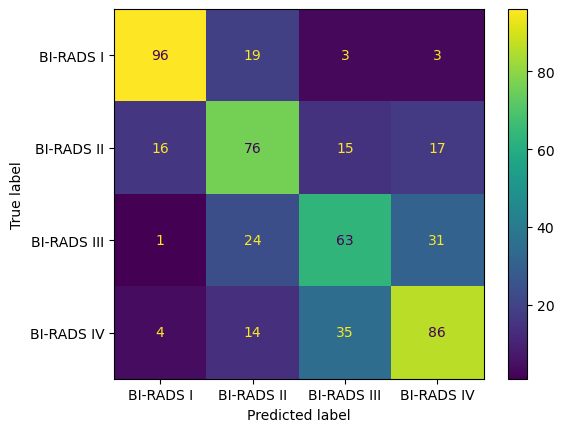

In [55]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [148]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.6600
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       121
           1       0.62      0.65      0.64       124
           2       0.55      0.54      0.54       119
           3       0.61      0.62      0.62       139

    accuracy                           0.66       503
   macro avg       0.66      0.66      0.66       503
weighted avg       0.66      0.66      0.66       503



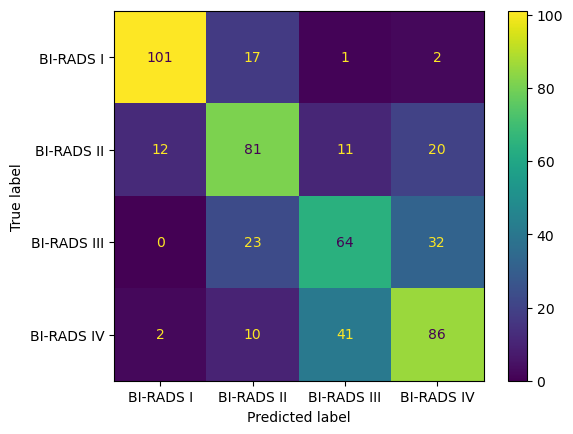

In [149]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

# Laplacian Dataset

In [150]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Laplacian(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

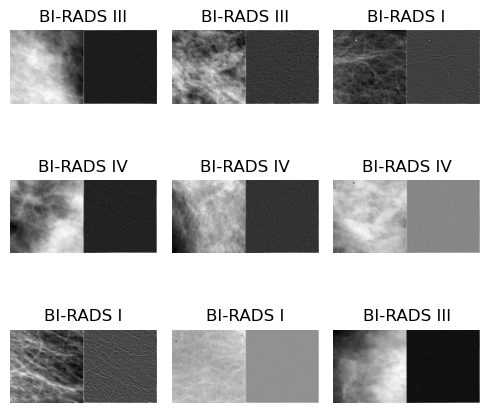

In [151]:
sample_images(dataloaders['test'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

## VAE

In [152]:
kwargs, state = torch.load("models/final/laplacian/vae.pt")

model = VAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

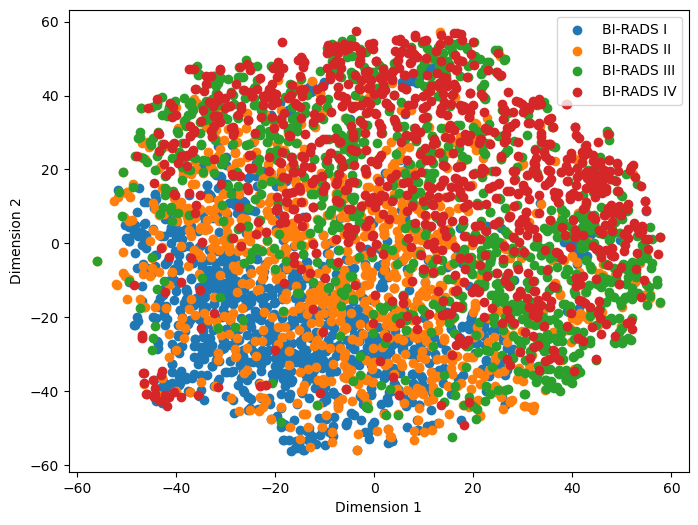

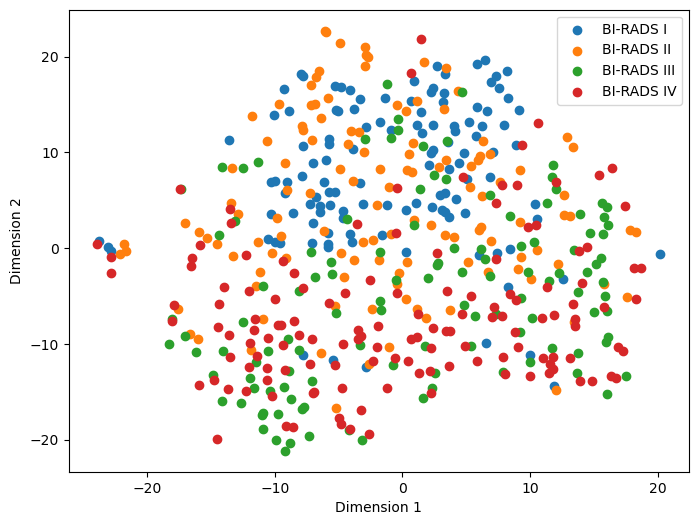

In [153]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [154]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [155]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [156]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)

In [157]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       121
           1       0.54      0.53      0.54       124
           2       0.55      0.54      0.54       119
           3       0.61      0.60      0.60       139

    accuracy                           0.60       503
   macro avg       0.60      0.60      0.60       503
weighted avg       0.60      0.60      0.60       503



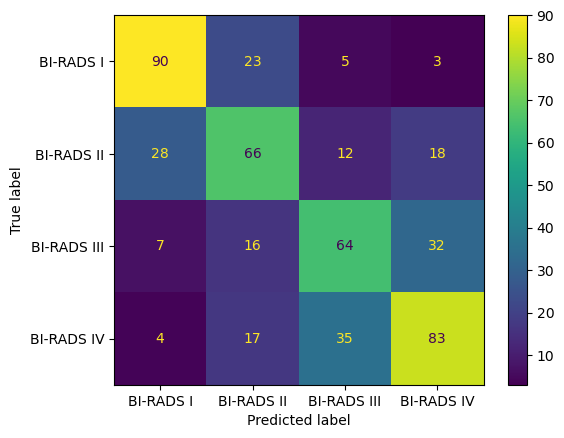

In [158]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [159]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.6024
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       121
           1       0.54      0.53      0.54       124
           2       0.55      0.54      0.54       119
           3       0.61      0.60      0.60       139

    accuracy                           0.60       503
   macro avg       0.60      0.60      0.60       503
weighted avg       0.60      0.60      0.60       503



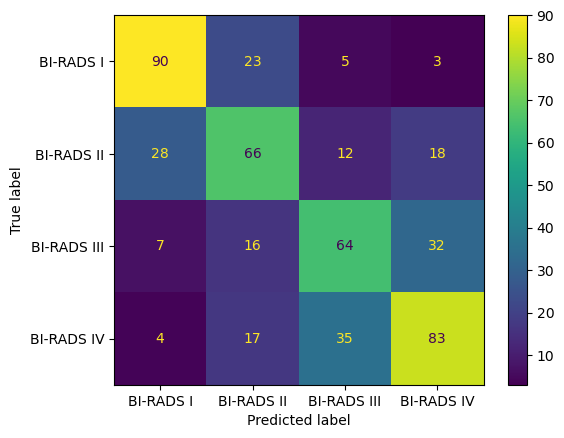

In [160]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [161]:
kwargs, state = torch.load("models/final/laplacian/pvae.pt")

model = PVAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

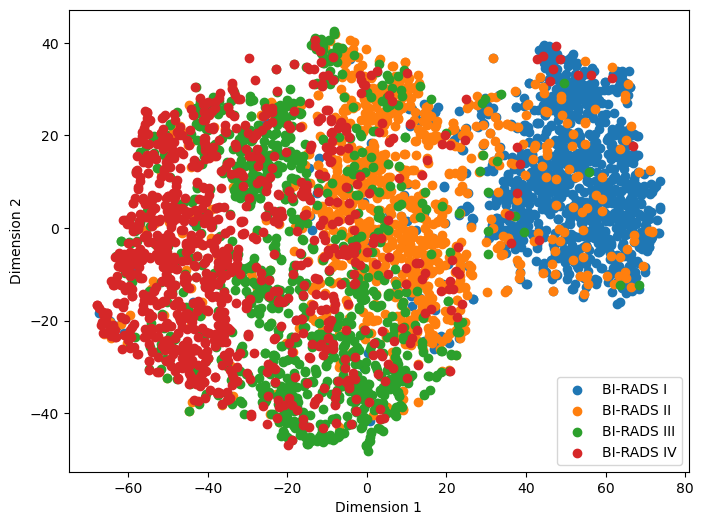

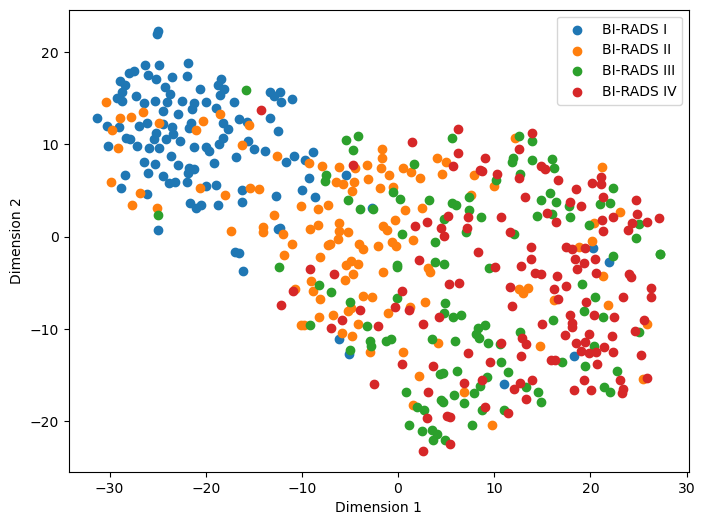

In [162]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [163]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [164]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [165]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(sum(y_pred == labels) / len(labels))

0.6401590457256461


In [166]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       121
           1       0.57      0.57      0.57       124
           2       0.58      0.58      0.58       119
           3       0.62      0.60      0.61       139

    accuracy                           0.64       503
   macro avg       0.64      0.64      0.64       503
weighted avg       0.64      0.64      0.64       503



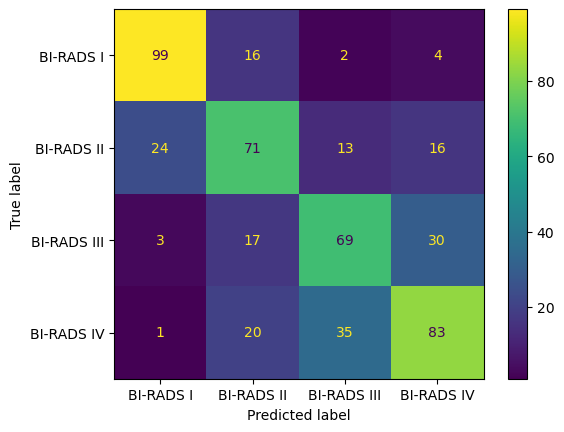

In [167]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [168]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.6402
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       121
           1       0.57      0.57      0.57       124
           2       0.58      0.58      0.58       119
           3       0.62      0.60      0.61       139

    accuracy                           0.64       503
   macro avg       0.64      0.64      0.64       503
weighted avg       0.64      0.64      0.64       503



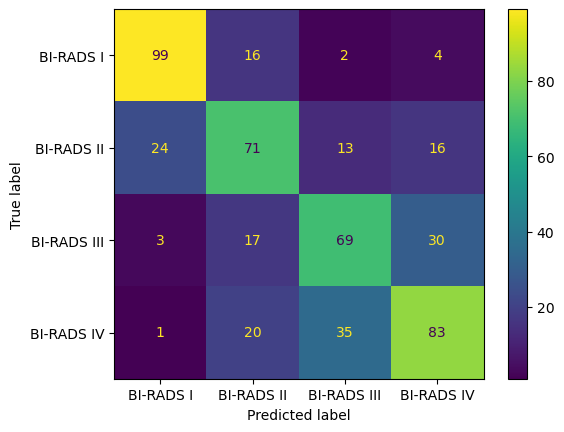

In [169]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

# Laplacian (add) Dataset

In [3]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            Laplacian('add', kernel='negative'),
            HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

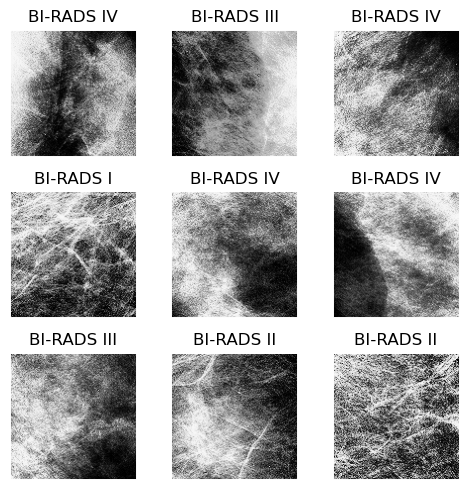

In [4]:
sample_images(dataloaders['test'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

## VAE

In [218]:
kwargs, state = torch.load("models/final/laplacian_inplace/vae.pt")

model = VAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

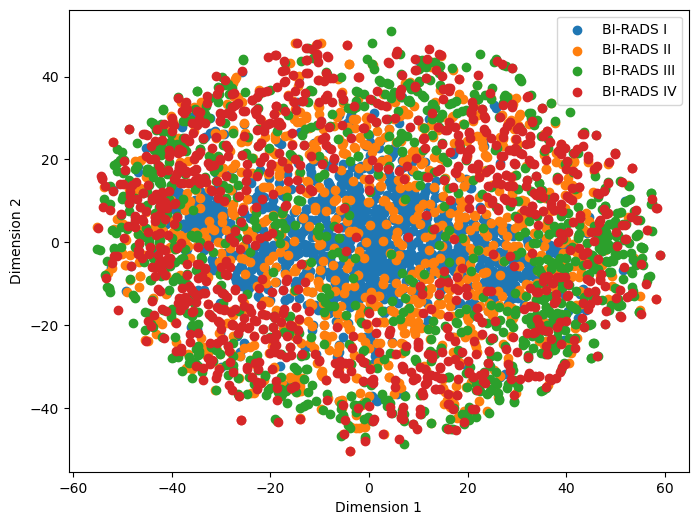

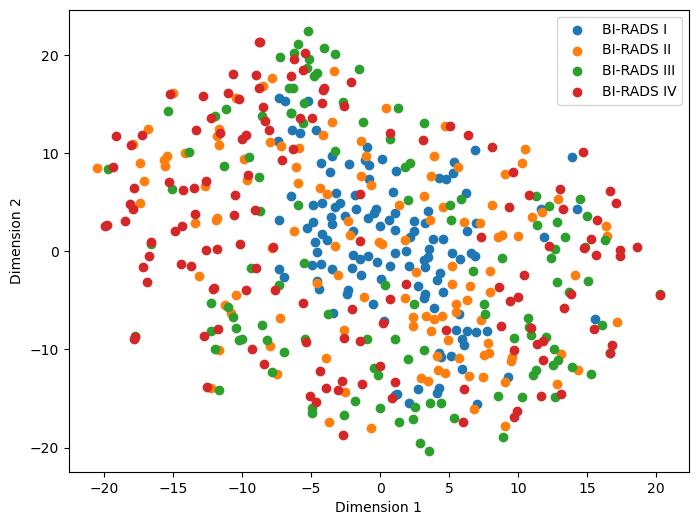

In [219]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [220]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [221]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [222]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)

In [223]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       121
           1       0.50      0.41      0.45       124
           2       0.47      0.58      0.52       119
           3       0.54      0.51      0.52       139

    accuracy                           0.56       503
   macro avg       0.56      0.56      0.56       503
weighted avg       0.56      0.56      0.56       503



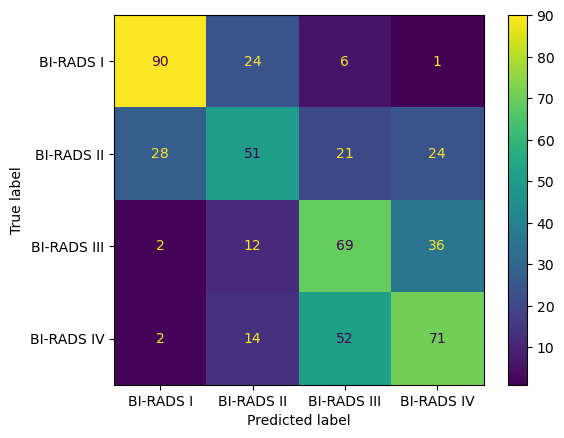

In [224]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [225]:
xgb = XGBClassifier()
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.5586
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       121
           1       0.50      0.41      0.45       124
           2       0.47      0.58      0.52       119
           3       0.54      0.51      0.52       139

    accuracy                           0.56       503
   macro avg       0.56      0.56      0.56       503
weighted avg       0.56      0.56      0.56       503



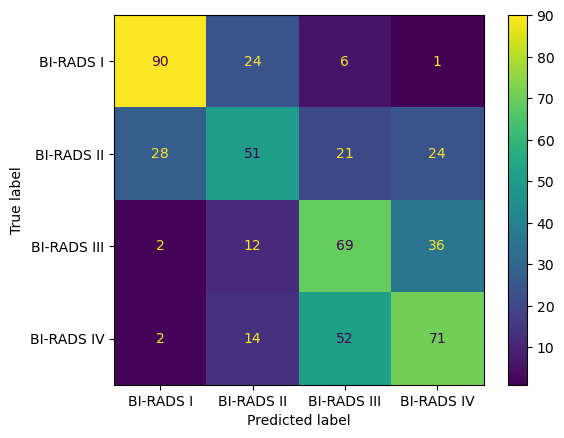

In [226]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [227]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 512),
    torch.nn.GELU(),
    torch.nn.Linear(512, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 512]                 33,280
├─GELU: 1-2                              [32, 512]                 --
├─Linear: 1-3                            [32, 256]                 131,328
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 206,020
Trainable params: 206,020
Non-trainable params: 0
Total mult-adds (M): 6.59
Input size (MB): 0.01
Forward/backward p

In [228]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.000005)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3862 - train_predict_loss: 1.3862 - train_accuracy: 0.2591 - val_loss: 1.3868 - val_predict_loss: 1.3868 - val_accuracy: 0.2604
[epoch: 2] train_loss: 1.3857 - train_predict_loss: 1.3857 - train_accuracy: 0.2850 - val_loss: 1.3864 - val_predict_loss: 1.3864 - val_accuracy: 0.2744
[epoch: 3] train_loss: 1.3852 - train_predict_loss: 1.3852 - train_accuracy: 0.3026 - val_loss: 1.3859 - val_predict_loss: 1.3859 - val_accuracy: 0.2803
[epoch: 4] train_loss: 1.3845 - train_predict_loss: 1.3845 - train_accuracy: 0.3136 - val_loss: 1.3852 - val_predict_loss: 1.3852 - val_accuracy: 0.2783
[epoch: 5] train_loss: 1.3836 - train_predict_loss: 1.3836 - train_accuracy: 0.3153 - val_loss: 1.3843 - val_predict_loss: 1.3843 - val_accuracy: 0.2724
[epoch: 6] train_loss: 1.3823 - train_predict_loss: 1.3823 - train_accuracy: 0.3166 - val_loss: 1.3830 - val_predict_loss: 1.3830 - val_accuracy: 0.2724
[epoch: 7] train_loss: 1.3805 - train_predict_loss: 1.3805 - train_accuracy: 0.317

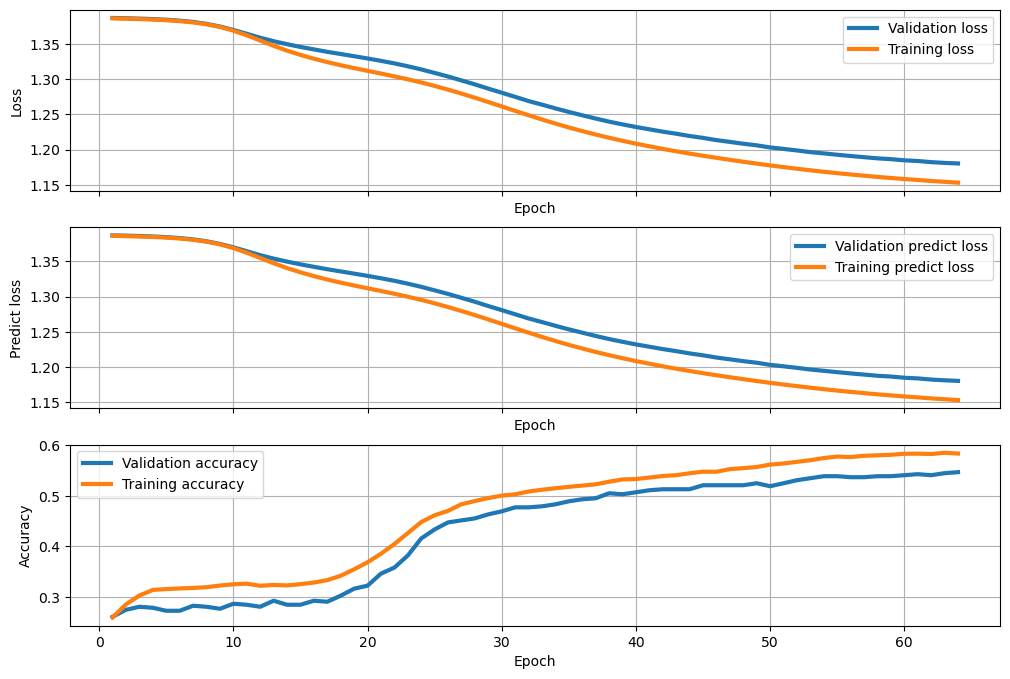

In [229]:
plot_history(hist)

In [230]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1826 - test_predict_loss: 1.1826 - test_accuracy: 0.5586


In [231]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       121
           1       0.46      0.31      0.38       124
           2       0.48      0.66      0.56       119
           3       0.56      0.50      0.53       139

    accuracy                           0.56       503
   macro avg       0.55      0.56      0.55       503
weighted avg       0.55      0.56      0.55       503



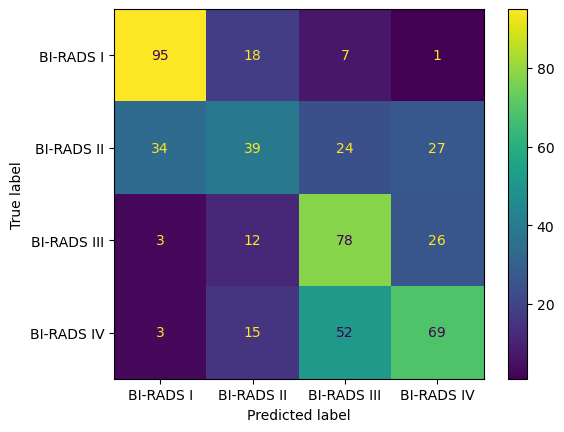

In [232]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [5]:
kwargs, state = torch.load("models/final/laplacian_inplace/pvae.pt")

model = PVAE(**kwargs)
model.load_state_dict(state)

summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [14]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, data, inv_normalize=None, n=4, device=None, plot_borders=False, label_mapper=lambda l: l):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = device

    fig, axs = plt.subplots(2, n)
    if plot_borders:
        fig.set_figwidth(16)

    with torch.no_grad():
        for i, data in enumerate(data, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            labels = label_mapper(labels.cpu())

            for ax, reconstructed, original, label in zip(range(n), outputs[0], inputs, labels):
                if inv_normalize is not None:
                    reconstructed = inv_normalize(reconstructed)      # unnormalize
                    original = inv_normalize(original)                # unnormalize

                # reco = reconstructed[0].cpu()
                if plot_borders:
                    fig.set_figwidth(16)
                    reconstructed_fig = np.concatenate((reconstructed[0].cpu(), reconstructed[1].cpu()), axis=1)
                    original_fig = np.concatenate((original[0].cpu(), original[1].cpu()), axis=1)
                else:
                    fig.set_figwidth(8)
                    reconstructed_fig = reconstructed[0].cpu()
                    original_fig = original[0].cpu()
                axs[0][ax].imshow(reconstructed_fig, cmap='gray')
                # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
                axs[1][ax].imshow(original_fig, cmap='gray')
                # axs[1][ax].imshow(original.cpu().permute(1,2,0))
                if ax == 0:
                    axs[1][ax].set_ylabel('Original')
                    axs[0][ax].set_ylabel('Reconstruction')

                axs[0][ax].set_yticks([])
                axs[0][ax].set_xticks([])
                axs[1][ax].set_yticks([])
                axs[1][ax].set_xticks([])
                
                axs[0][ax].set_title(str(label.item()))  # Set label as title for each image
            plt.show()

            break

test_loss: 6.1525 - test_rec_loss: 4.9485 - test_kl_loss: 0.0686 - test_pred_loss: 1.1354 - test_accuracy: 0.6004


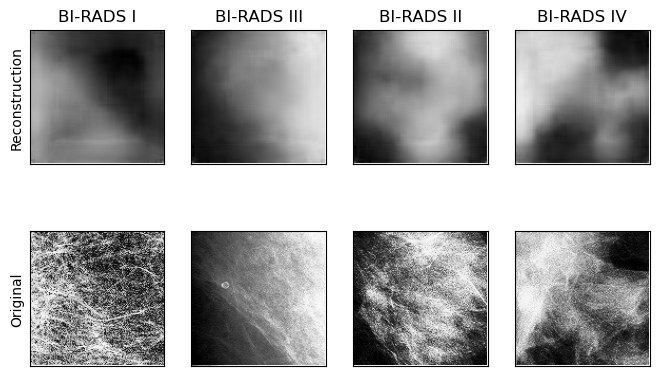

In [17]:
test_metrics = validate(model, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=False, label_mapper=IrmaDataset.get_class_label)

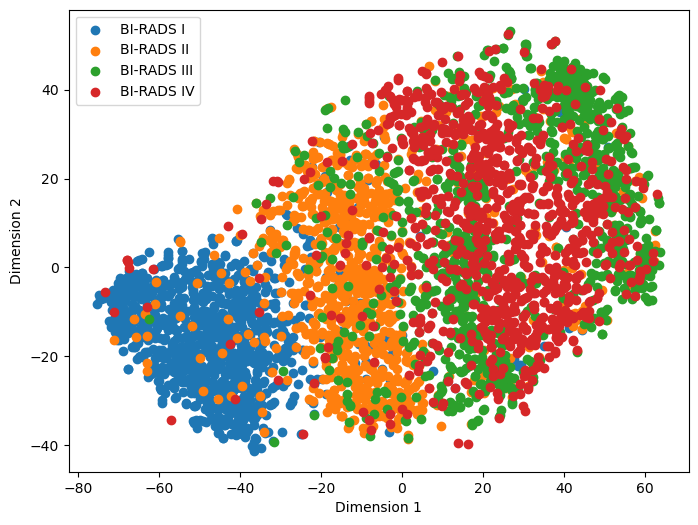

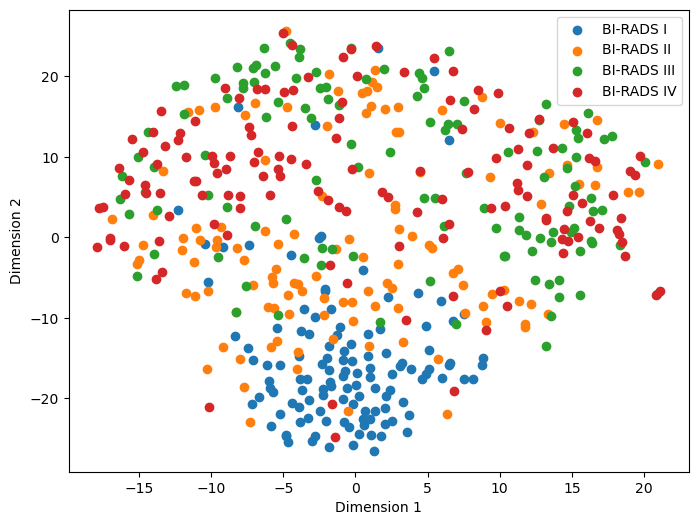

In [182]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [183]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [184]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [185]:
svm = SVC()
svm.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(sum(y_pred == labels) / len(labels))

0.6441351888667992


In [186]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       121
           1       0.62      0.63      0.62       124
           2       0.49      0.56      0.53       119
           3       0.62      0.58      0.60       139

    accuracy                           0.64       503
   macro avg       0.65      0.65      0.65       503
weighted avg       0.65      0.64      0.65       503



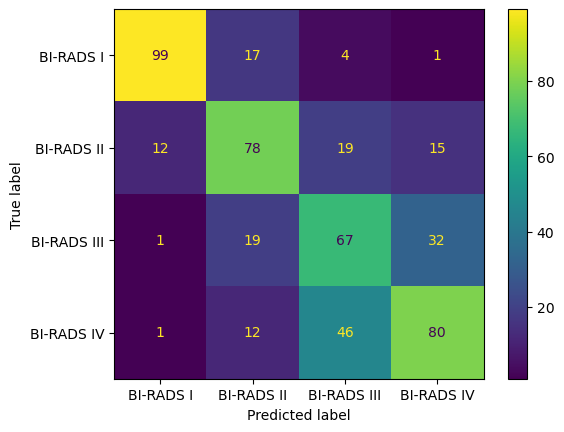

In [187]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [204]:
xgb = XGBClassifier(device='cuda', n_estimators=100)
xgb.fit(train_latent, train_labels)
y_pred = svm.predict(latent)
print(f'accuracy: {(sum(y_pred == labels)/len(latent)):.4f}')
print(classification_report(labels, y_pred))

accuracy: 0.6441
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       121
           1       0.62      0.63      0.62       124
           2       0.49      0.56      0.53       119
           3       0.62      0.58      0.60       139

    accuracy                           0.64       503
   macro avg       0.65      0.65      0.65       503
weighted avg       0.65      0.64      0.65       503



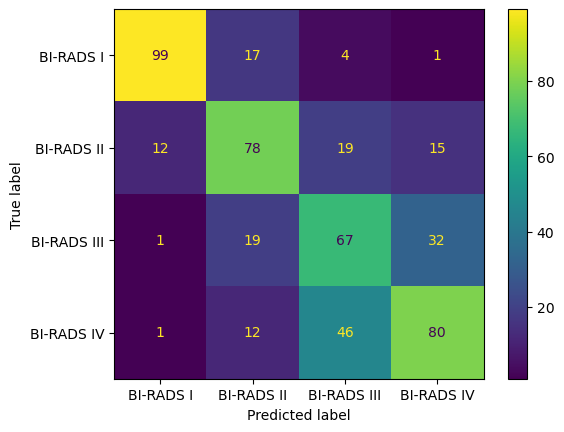

In [205]:
cm = confusion_matrix(labels, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [206]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 512),
    torch.nn.GELU(),
    torch.nn.Linear(512, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 512]                 33,280
├─GELU: 1-2                              [32, 512]                 --
├─Linear: 1-3                            [32, 256]                 131,328
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 206,020
Trainable params: 206,020
Non-trainable params: 0
Total mult-adds (M): 6.59
Input size (MB): 0.01
Forward/backward p

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.000005)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3850 - train_predict_loss: 1.3850 - train_accuracy: 0.2511 - val_loss: 1.3851 - val_predict_loss: 1.3851 - val_accuracy: 0.2505
[epoch: 2] train_loss: 1.3828 - train_predict_loss: 1.3828 - train_accuracy: 0.2516 - val_loss: 1.3829 - val_predict_loss: 1.3829 - val_accuracy: 0.2545
[epoch: 3] train_loss: 1.3796 - train_predict_loss: 1.3796 - train_accuracy: 0.2979 - val_loss: 1.3794 - val_predict_loss: 1.3794 - val_accuracy: 0.3360
[epoch: 4] train_loss: 1.3743 - train_predict_loss: 1.3743 - train_accuracy: 0.4532 - val_loss: 1.3731 - val_predict_loss: 1.3731 - val_accuracy: 0.4433
[epoch: 5] train_loss: 1.3644 - train_predict_loss: 1.3644 - train_accuracy: 0.5523 - val_loss: 1.3610 - val_predict_loss: 1.3610 - val_accuracy: 0.4692
[epoch: 6] train_loss: 1.3451 - train_predict_loss: 1.3451 - train_accuracy: 0.5548 - val_loss: 1.3372 - val_predict_loss: 1.3372 - val_accuracy: 0.4891
[epoch: 7] train_loss: 1.3106 - train_predict_loss: 1.3106 - train_accuracy: 0.534

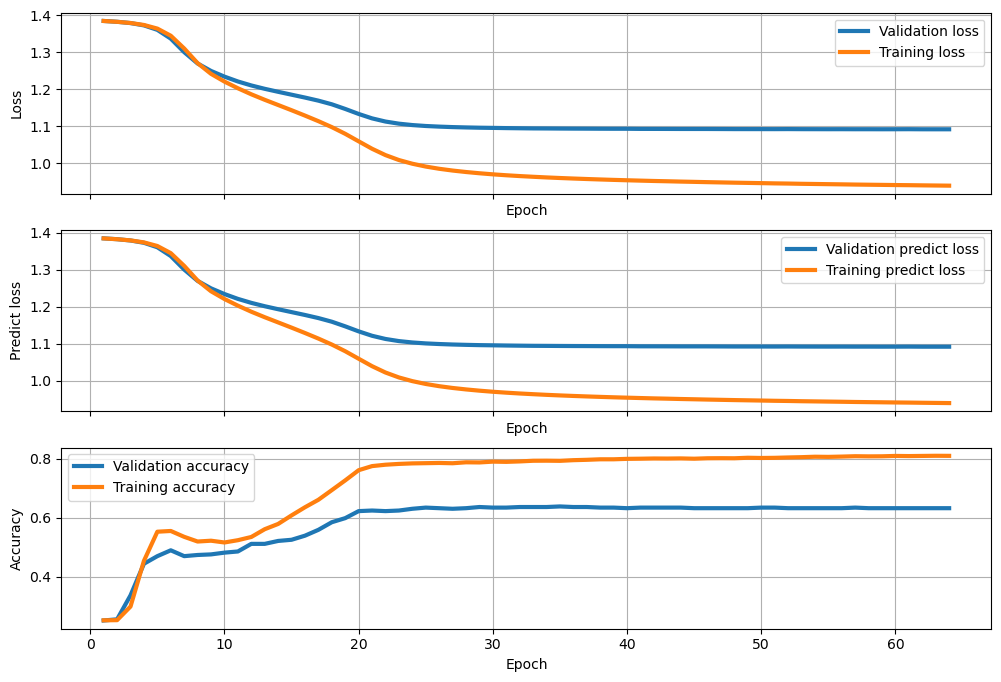

In [208]:
plot_history(hist)

In [209]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0996 - test_predict_loss: 1.0996 - test_accuracy: 0.6302


In [210]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       121
           1       0.62      0.60      0.61       124
           2       0.47      0.53      0.50       119
           3       0.60      0.58      0.59       139

    accuracy                           0.63       503
   macro avg       0.64      0.63      0.63       503
weighted avg       0.64      0.63      0.63       503



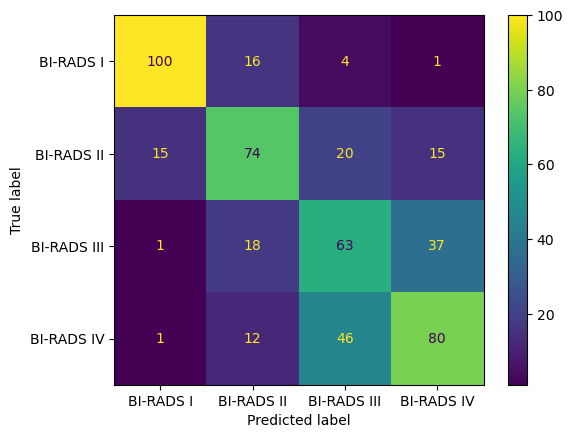

In [211]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()